## Tutorial 104: Generate 21 ADME Predictors with 10 Lines of Code

[Kexin](https://twitter.com/KexinHuang5)

In the previous set of tutorials, hopefully, you are now familiarized with TDC. In this tutorial, we show through examples how to use TDC for fast ML model prototyping using DeepPurpose. Let's start introducing what is DeepPurpose.

### DeepPurpose Overview
DeepPurpose is a scikit learn style Deep Learning Based Molecular Modeling and Prediction Toolkit on Drug-Target Interaction Prediction, Compound Property Prediction, Protein-Protein Interaction Prediction, and Protein Function prediction. Using DeepPurpose, we can rapidly build model prototypes for various drug discovery tasks covered in TDC, such as ADME, Tox, HTS, Developability prediction, DTI, DDI, PPI, Antibody Affinity predictions. 

Note that DeepPurpose is developed by two of the core teams in TDC, Kexin and Tianfan, and it is now published in Bioinformatics. To start with this tutorial, please follow [DeepPurpose instructions](https://github.com/kexinhuang12345/DeepPurpose#install--usage) to set up the necessary packages. DeepPurpose also provides [tutorials](https://github.com/kexinhuang12345/DeepPurpose/blob/master/Tutorial_1_DTI_Prediction.ipynb) for you to familiarize with it. 

To install DeepPurpose, in your terminal, do the following:

```bash
conda create -n DeepPurpose python=3.6
conda activate DeepPurpose
conda install -c conda-forge rdkit
pip install git+https://github.com/bp-kelley/descriptastorus 
pip install DeepPurpose
pip install PyTDC --upgrade
```

And then open this jupyter notebook using this conda environment.

We assume now you have set up the right environment. Now, we show you how to build an ADME predictor using Message Passing Neural Network (MPNN)! 

### Predicting HIA using MPNN with 10 Lines of Code

First, let's load DeepPurpose and TDC:

In [1]:
from DeepPurpose import utils, CompoundPred
from tdc.single_pred import ADME

Now, you can get the HIA dataset from TDC. HIA is from ADME task from Single-instance prediction and we want to predict whether or not can a compound be absorped in human intestinal, i.e. given SMILES X, predict 1/0. Note that for drug property prediction, DeepPurpose takes in an array of drug SMILES string and an array of labels. You could access that directly by setting the `get_data(format = 'dict')`:

In [2]:
data = ADME(name = 'HIA_Hou').get_data(format = 'dict')
X, y = data['Drug'], data['Y']

Downloading...
100%|██████████| 48.1k/48.1k [00:00<00:00, 588kiB/s]
Loading...
Done!


or for simplicity. We also provide a DeepPurpose format, where you can directly get the correct input data:

In [3]:
X, y = ADME(name = 'HIA_Hou').get_data(format = 'DeepPurpose')

Found local copy...
Loading...
Done!


DeepPurpose provides 8 encoders for compound, ranging from MLP on classic cheminformatics fingerprint such as Morgan, RDKit2D to deep learning models such as CNN, transformer, and MPNN. To specify the encoder, simply types the encoder name. Here, we use MPNN as an example:

In [4]:
drug_encoding = 'MPNN'

Now, we encode the data into the specified format, using `utils.data_process` function. It specifies train/validation/test split fractions, and random seed to ensure same data splits for reproducibility. **We have made DeepPurpose to accomodate the TDC benchmark split.** Simply type 'TDC' in the random seed will generate the same split as in TDC split function. The function outputs train, val, test pandas dataframes.

In [5]:
train, val, test = utils.data_process(X_drug = X, 
                                      y = y, 
                                      drug_encoding = drug_encoding,
                                      random_seed = 'TDC')

Drug Property Prediction Mode...
in total: 578 drugs
encoding drug...
unique drugs: 578
Done.


In [6]:
train.head(2)

,SMILES,Label,drug_encoding
0,CC(=O)N/C1=C/C=CC=C1,1,"[[[tensor(1.), tensor(0.), tensor(0.), tensor(..."
1,CC(=O)N/C1=N/N=C([S]1)[S](N)(=O)=O,1,"[[[tensor(1.), tensor(0.), tensor(0.), tensor(..."


After we have the dataset, you can set up the model configuration such as dimension, # of layers, optimization parameters and etc. As an example, we set the following configurations (we set train epochs to be 3 here for demonstration purpose):

In [7]:
config = utils.generate_config(drug_encoding = drug_encoding, 
                         train_epoch = 3, 
                         LR = 0.001, 
                         batch_size = 128,
                         mpnn_hidden_size = 32,
                         mpnn_depth = 2
                        )

Now, you need to initialize the model. You can also load from pretrained model by `CompoundPred.model_pretrained(path_dir = PATH)`. Here, we initialize a new model:

In [8]:
model = CompoundPred.model_initialize(**config)

That's it. Now, you can train it!

Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68003. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.63305 , AUPRC: 0.93538 , F1: 0.93577
Training at Epoch 2 iteration 0 with loss 0.31937. Total time 0.00027 hours
Validation at Epoch 2 , AUROC: 0.69467 , AUPRC: 0.94949 , F1: 0.93577
Training at Epoch 3 iteration 0 with loss 0.37782. Total time 0.00027 hours
Validation at Epoch 3 , AUROC: 0.71148 , AUPRC: 0.95229 , F1: 0.93577
--- Go for Testing ---
Testing AUROC: 0.7716171617161716 , AUPRC: 0.9609550419886628 , F1: 0.9308755760368664
--- Training Finished ---


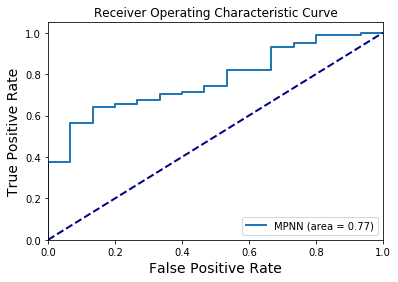

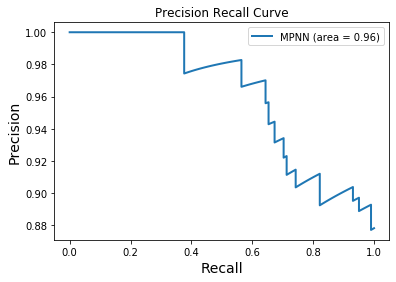

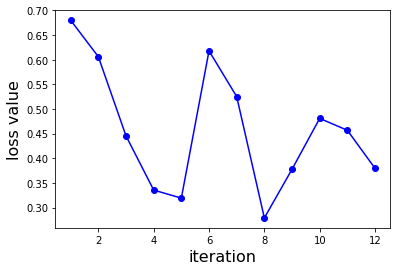

In [9]:
# Training
model.train(train, val, test)

In less than 1 minute with a CPU, you can already get pretty good performance! Now, you can save the model by typing:

In [10]:
model.save_model('./tutorial_model')

You may already notice that the whole thing can be streamlined for all the ADME tasks in TDC by simply specifying different dataset names. To generate a full set of ADME predictors, you can do:

In [ ]:
from tdc.utils import retrieve_dataset_names
adme_datasets = retrieve_dataset_names('ADME')

for dataset_name in adme_datasets:
    X, y = ADME(name = dataset_name).get_data(format = 'DeepPurpose')
    drug_encoding = 'Morgan'
    train, val, test = utils.data_process(X_drug = X, 
                                      y = y, 
                                      drug_encoding = drug_encoding,
                                      random_seed = 'TDC')
    config = utils.generate_config(drug_encoding = drug_encoding, 
                         train_epoch = 5, 
                         LR = 0.001, 
                         batch_size = 128,
                         mpnn_hidden_size = 32,
                         mpnn_depth = 2
                        )
    model = CompoundPred.model_initialize(**config)
    model.train(train, val, test)
    model.save_model('./' + dataset_name + '_model')

We have tested the above code and it would print out all the training process. We omit the output here since it is a bit long. But hopefully, you could get the gist of it. DeepPurpose also allows to do similar modeling for DTI, DDI, PPI and protein function prediction! Checkout the [repository](https://github.com/kexinhuang12345/DeepPurpose)!

That's it for this tutorial!